<a href="https://colab.research.google.com/github/simonamador/EEG-Channel-Selection-Algorithm/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne

from google.colab import drive
drive.mount('/content/drive')
import numpy as np
from scipy.stats import mode
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.4 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
#Se extraen archivos de data preprocesada de EEG
with np.load('/content/drive/MyDrive/Colab Notebooks/Datosfiltrados/SubjectsData.npz', allow_pickle=True) as data:
  X = data['X']
  y = data['y']
del data #Se elimina para que no ocupe RAM

In [ ]:
def findaccuraciesMLPNN(n,X,y,ch):
  X_tr, X_ts, y_train, y_test = train_test_split(
      X[:,ch,:], y, test_size=0.2, random_state=42)
  X_train, X_test = np.empty(shape=(X_tr.shape[0],n,113,1)), np.empty(shape=(X_ts.shape[0],n,113,1))
  X_train[:,:,:,0], X_test[:,:,:,0] = X_tr, X_ts
  #Generar modelo de MPLNN. 
  tf.random.set_seed(42)
  modelMLPNN = models.Sequential([
      layers.Flatten(input_shape=(n,113,1)),
      layers.Dense(25, activation='linear'),
      layers.Dense(25, activation='linear'),
      layers.Dense(25, activation='linear'),
      layers.Dense(2, activation='softmax')
  ])

  modelMLPNN.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
  history = modelMLPNN.fit(X_train, y_train, epochs=2, 
                    validation_data=(X_test, y_test))
  test_loss, test_acc = modelMLPNN.evaluate(X_test,  y_test, verbose=2)
  return test_acc

def findaccuraciesCNN(n,X,y,ch):
  X_tr, X_ts, y_train, y_test = train_test_split(
      X[:,ch,:], y, test_size=0.2, random_state=42)
  X_train, X_test = np.empty(shape=(X_tr.shape[0],n,113,1)), np.empty(shape=(X_ts.shape[0],n,113,1))
  X_train[:,:,:,0], X_test[:,:,:,0] = X_tr, X_ts
  #Generar modelo de CNN inspirado en modelo de Llorente-Vidrio et al. 
  tf.random.set_seed(42)
  modelCNN = models.Sequential([
      layers.Conv2D(3, (n, n), activation='linear', input_shape=(n,113,1)),
      layers.Conv2D(3, (1, 1), activation='linear'),
      layers.Flatten(),
      layers.Dense(25, activation='linear'),
      layers.Dense(25, activation='linear'),
      layers.Dense(25, activation='linear'),
      layers.Dense(2, activation='softmax')
  ])

  modelCNN.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
  history = modelCNN.fit(X_train, y_train, epochs=2, 
                    validation_data=(X_test, y_test))
  test_loss, test_acc = modelCNN.evaluate(X_test,  y_test, verbose=2)
  return test_acc

In [ ]:
channels = np.array(['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 
            'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3',
            'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 
            'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3',
            'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 
            'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5',
            'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8','PO7',
            'PO3','POz','PO4','PO8','O1','Oz','O2','Iz'])


In [ ]:
ynew=[]
xnew=[]
#Reduccion a dos clases
for s in range(109):
  if s in [87,91,99]:
    continue
  else:
    yline =[]
    xline =[]
    for i in range(y[s].size):
      if y[s][i] in [1,2]:
        yline.append(y[s][i]-1)
        xline.append(X[s][i])
    yline = np.array(yline)
    ynew.append(yline)
    xline = np.array(xline)
    xnew.append(xline)
X = xnew
y = ynew

#Normalizacion
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(len(X)):
  for c in range(64):
    X[i][:,c,:] = scaler.fit_transform(X[i][:,c,:])

del xline, yline, s, i, c, xnew, ynew, scaler

In [ ]:
for s in range(len(X)):
  totvar = []
  idealvar = []
  top_comp = []
  for x in range(X[s].shape[0]):
    pca = PCA(n_components=64)
    X_new = pca.fit_transform(np.transpose(X[s][x]))
    var = pca.explained_variance_ratio_
    comp = pca.components_ 
    idealvar.append(sum(var[:6]))
    n_totvar = [var[i]*np.max(abs(comp[i])) for i in range(6)]
    totvar.append(sum(n_totvar))
    top_comp.append(np.argsort(abs(pca.components_ ), axis =-1)[:6,-1].flatten())
  ch = mode(top_comp)[0]
  acc1 = findaccuraciesMLPNN(1,X[s],y[s],[ch[0,0]])
  acc3 = findaccuraciesMLPNN(3,X[s],y[s],ch[0,0:3])
  acc6 = findaccuraciesMLPNN(6,X[s],y[s],ch[0,0:6])
  np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/Datosfiltrados/PCA/MLPNN/Subject'+str(s+1)+'.npz', 
                  totvar = totvar, 
                  top_comp = top_comp,
                  idealvar = idealvar, 
                  acc = np.array([acc1, acc3, acc6], dtype=object),
                  allow_pickle=True)

Epoch 1/2


<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 180ms/step - loss: 0.6943 - accuracy: 0.5833 - val_loss: 0.5975 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.6974 - accuracy: 0.5833 - val_loss: 0.5624 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5624 - accuracy: 0.7778 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 0.7714 - accuracy: 0.4167 - val_loss: 0.9746 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.7155 - accuracy: 0.6111 - val_loss: 0.6186 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6186 - accuracy: 0.7778 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 185ms/step - loss: 0.7352 - accuracy: 0.5833 - val_loss: 0.5605 - val_accuracy: 0.8889
Epoch 2/2
2/2 [==============================] - 0s 42ms/step - loss: 0.7513 - accuracy: 0.4167 - val_loss: 1.3923 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.3923 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 240ms/step - loss: 1.2251 - accuracy: 0.4167 - val_loss: 0.6584 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 22ms/step - loss: 0.7797 - accuracy: 0.4444 - val_loss: 0.9784 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.9784 - accuracy: 0.3333 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 148ms/step - loss: 1.5914 - accuracy: 0.5833 - val_loss: 0.8203 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.7356 - accuracy: 0.5556 - val_loss: 0.4182 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.4182 - accuracy: 0.7778 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 331ms/step - loss: 0.8043 - accuracy: 0.5000 - val_loss: 1.0322 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 43ms/step - loss: 0.7273 - accuracy: 0.5556 - val_loss: 0.6165 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6165 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 166ms/step - loss: 0.8388 - accuracy: 0.3611 - val_loss: 0.7485 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.7335 - accuracy: 0.5000 - val_loss: 0.9051 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.9051 - accuracy: 0.3333 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 144ms/step - loss: 0.7881 - accuracy: 0.6389 - val_loss: 0.4839 - val_accuracy: 0.8889
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.9023 - accuracy: 0.4167 - val_loss: 0.6209 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6209 - accuracy: 0.6667 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 1s 153ms/step - loss: 0.7548 - accuracy: 0.5278 - val_loss: 0.5314 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.7330 - accuracy: 0.4444 - val_loss: 1.3240 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.3240 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 138ms/step - loss: 0.8431 - accuracy: 0.5556 - val_loss: 0.9084 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.7036 - accuracy: 0.5833 - val_loss: 0.7305 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.7305 - accuracy: 0.3333 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 1s 158ms/step - loss: 0.7424 - accuracy: 0.5278 - val_loss: 0.7812 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.6817 - accuracy: 0.6389 - val_loss: 0.5186 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5186 - accuracy: 0.7778 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 148ms/step - loss: 0.6918 - accuracy: 0.5556 - val_loss: 0.8218 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.6462 - accuracy: 0.6111 - val_loss: 1.3397 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.3397 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 210ms/step - loss: 1.4495 - accuracy: 0.4167 - val_loss: 0.5316 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.9875 - accuracy: 0.4167 - val_loss: 0.6263 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.6263 - accuracy: 0.5556 - 22ms/epoch - 22ms/step
Epoch 1/2
2/2 [==============================] - 1s 253ms/step - loss: 1.2879 - accuracy: 0.4167 - val_loss: 0.9955 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 39ms/step - loss: 0.7189 - accuracy: 0.6111 - val_loss: 1.4604 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.4604 - accuracy: 0.2222 - 20ms/epoch - 20ms/step
Epoch 1/2
2/2 [==============================] - 1s 154ms/step - loss: 0.8731 - accuracy: 0.4722 - val_loss: 0.9756 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 31ms/step - loss: 0.8024 - accuracy: 0.6111 - val_loss: 0.4835 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.4835 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 163ms/step - loss: 0.9499 - accuracy: 0.4722 - val_loss: 0.6799 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.7021 - accuracy: 0.4722 - val_loss: 0.9906 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9906 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 149ms/step - loss: 1.0727 - accuracy: 0.4444 - val_loss: 0.8755 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.8078 - accuracy: 0.5000 - val_loss: 0.7614 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.7614 - accuracy: 0.3333 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 142ms/step - loss: 1.0090 - accuracy: 0.5556 - val_loss: 0.7208 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.9283 - accuracy: 0.4444 - val_loss: 1.8594 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.8594 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 146ms/step - loss: 0.8270 - accuracy: 0.4444 - val_loss: 0.9482 - val_accuracy: 0.1111
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7118 - accuracy: 0.5556 - val_loss: 1.0880 - val_accuracy: 0.1111
1/1 - 0s - loss: 1.0880 - accuracy: 0.1111 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 156ms/step - loss: 0.7279 - accuracy: 0.5000 - val_loss: 0.6872 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6809 - accuracy: 0.6667 - val_loss: 0.8079 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.8079 - accuracy: 0.3333 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 152ms/step - loss: 1.1035 - accuracy: 0.4167 - val_loss: 1.4465 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.8876 - accuracy: 0.5833 - val_loss: 0.7471 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.7471 - accuracy: 0.3333 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 141ms/step - loss: 1.1165 - accuracy: 0.4444 - val_loss: 0.8242 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.8224 - accuracy: 0.3889 - val_loss: 1.1060 - val_accuracy: 0.1111
1/1 - 0s - loss: 1.1060 - accuracy: 0.1111 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 211ms/step - loss: 0.7744 - accuracy: 0.5278 - val_loss: 0.8323 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.7052 - accuracy: 0.5278 - val_loss: 0.6122 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6122 - accuracy: 0.6667 - 22ms/epoch - 22ms/step
Epoch 1/2
2/2 [==============================] - 1s 185ms/step - loss: 0.9524 - accuracy: 0.5556 - val_loss: 0.6542 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 49ms/step - loss: 1.0662 - accuracy: 0.4167 - val_loss: 0.9180 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9180 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 145ms/step - loss: 0.6979 - accuracy: 0.5278 - val_loss: 0.9906 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 22ms/step - loss: 0.6776 - accuracy: 0.6389 - val_loss: 0.9203 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9203 - accuracy: 0.2222 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 158ms/step - loss: 0.7226 - accuracy: 0.5278 - val_loss: 0.8226 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.6867 - accuracy: 0.6667 - val_loss: 0.4660 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.4660 - accuracy: 0.7778 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 144ms/step - loss: 0.8173 - accuracy: 0.4722 - val_loss: 1.2251 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.7319 - accuracy: 0.5833 - val_loss: 0.5738 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5738 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 156ms/step - loss: 0.7347 - accuracy: 0.5000 - val_loss: 0.7513 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.7033 - accuracy: 0.6111 - val_loss: 0.6588 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6588 - accuracy: 0.7778 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 0.6753 - accuracy: 0.6111 - val_loss: 0.6025 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6973 - accuracy: 0.5000 - val_loss: 0.8064 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.8064 - accuracy: 0.3333 - 23ms/epoch - 23ms/step
Epoch 1/2
2/2 [==============================] - 1s 147ms/step - loss: 0.9157 - accuracy: 0.3889 - val_loss: 1.3389 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.7392 - accuracy: 0.6111 - val_loss: 0.9994 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9994 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 153ms/step - loss: 0.8276 - accuracy: 0.5556 - val_loss: 0.6756 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 48ms/step - loss: 0.6906 - accuracy: 0.5833 - val_loss: 0.5656 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5656 - accuracy: 0.7778 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 158ms/step - loss: 0.7490 - accuracy: 0.5000 - val_loss: 1.0124 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.7278 - accuracy: 0.5000 - val_loss: 0.6733 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6733 - accuracy: 0.6667 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 163ms/step - loss: 1.7784 - accuracy: 0.4167 - val_loss: 2.1541 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 1.0405 - accuracy: 0.5556 - val_loss: 1.5308 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.5308 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 229ms/step - loss: 0.7851 - accuracy: 0.3889 - val_loss: 0.8365 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 31ms/step - loss: 0.7014 - accuracy: 0.5556 - val_loss: 0.9055 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9055 - accuracy: 0.2222 - 21ms/epoch - 21ms/step
Epoch 1/2
2/2 [==============================] - 1s 192ms/step - loss: 1.0067 - accuracy: 0.6111 - val_loss: 0.6370 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.8052 - accuracy: 0.5278 - val_loss: 0.6069 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6069 - accuracy: 0.7778 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 146ms/step - loss: 0.8079 - accuracy: 0.6111 - val_loss: 0.6722 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 22ms/step - loss: 0.8684 - accuracy: 0.3611 - val_loss: 1.2971 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.2971 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 145ms/step - loss: 0.9100 - accuracy: 0.3611 - val_loss: 0.9688 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.8396 - accuracy: 0.5000 - val_loss: 0.9282 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.9282 - accuracy: 0.4444 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 140ms/step - loss: 1.2438 - accuracy: 0.3889 - val_loss: 1.1529 - val_accuracy: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.7291 - accuracy: 0.5278 - val_loss: 1.4744 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.4744 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 0.7446 - accuracy: 0.6389 - val_loss: 0.5767 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7601 - accuracy: 0.4444 - val_loss: 1.4514 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.4514 - accuracy: 0.2

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 147ms/step - loss: 0.7009 - accuracy: 0.5278 - val_loss: 0.6948 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.6911 - accuracy: 0.6111 - val_loss: 0.6983 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.6983 - accuracy: 0.4444 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 1.0113 - accuracy: 0.3889 - val_loss: 1.0865 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.8023 - accuracy: 0.5556 - val_loss: 1.1295 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.1295 - accuracy: 0.2222 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 144ms/step - loss: 0.7412 - accuracy: 0.4722 - val_loss: 0.9748 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.6990 - accuracy: 0.5556 - val_loss: 0.6604 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.6604 - accuracy: 0.5556 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 146ms/step - loss: 0.7436 - accuracy: 0.4444 - val_loss: 0.8523 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6679 - accuracy: 0.6944 - val_loss: 0.9636 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.9636 - accuracy: 0.3333 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 212ms/step - loss: 0.7527 - accuracy: 0.5833 - val_loss: 0.6359 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 33ms/step - loss: 0.7839 - accuracy: 0.4722 - val_loss: 0.7748 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7748 - accuracy: 0.4444 - 22ms/epoch - 22ms/step
Epoch 1/2
2/2 [==============================] - 1s 216ms/step - loss: 0.7680 - accuracy: 0.5278 - val_loss: 0.7376 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 37ms/step - loss: 0.7212 - accuracy: 0.5278 - val_loss: 1.3890 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.3890 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 138ms/step - loss: 0.7019 - accuracy: 0.5833 - val_loss: 0.8137 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 22ms/step - loss: 0.6874 - accuracy: 0.5833 - val_loss: 0.7657 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.7657 - accuracy: 0.3333 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 141ms/step - loss: 0.9947 - accuracy: 0.3611 - val_loss: 1.7216 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 33ms/step - loss: 0.9507 - accuracy: 0.5556 - val_loss: 0.6734 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6734 - accuracy: 0.6667 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 1s 146ms/step - loss: 1.2277 - accuracy: 0.4167 - val_loss: 2.0417 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.9859 - accuracy: 0.5833 - val_loss: 1.2715 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.2715 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 156ms/step - loss: 0.9215 - accuracy: 0.4444 - val_loss: 0.9554 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.7166 - accuracy: 0.4444 - val_loss: 1.2640 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.2640 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 139ms/step - loss: 0.8632 - accuracy: 0.3889 - val_loss: 1.3745 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 22ms/step - loss: 0.8097 - accuracy: 0.5556 - val_loss: 0.6905 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6905 - accuracy: 0.6667 - 21ms/epoch - 21ms/step
Epoch 1/2
2/2 [==============================] - 1s 144ms/step - loss: 0.8065 - accuracy: 0.4167 - val_loss: 1.0035 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 22ms/step - loss: 0.7181 - accuracy: 0.6389 - val_loss: 0.5612 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5612 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 141ms/step - loss: 0.7797 - accuracy: 0.5833 - val_loss: 0.8074 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 22ms/step - loss: 0.6711 - accuracy: 0.5278 - val_loss: 0.6569 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6569 - accuracy: 0.6667 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 142ms/step - loss: 0.9449 - accuracy: 0.4167 - val_loss: 1.0160 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.8446 - accuracy: 0.5556 - val_loss: 0.7858 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7858 - accuracy: 0.4444 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 143ms/step - loss: 0.7809 - accuracy: 0.5556 - val_loss: 0.6959 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.7938 - accuracy: 0.5278 - val_loss: 1.1203 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.1203 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 214ms/step - loss: 0.6956 - accuracy: 0.6111 - val_loss: 0.7192 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 39ms/step - loss: 0.6976 - accuracy: 0.6111 - val_loss: 0.8293 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.8293 - accuracy: 0.4444 - 22ms/epoch - 22ms/step
Epoch 1/2
2/2 [==============================] - 1s 143ms/step - loss: 0.7846 - accuracy: 0.4167 - val_loss: 1.1561 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.7251 - accuracy: 0.6111 - val_loss: 0.6796 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6796 - accuracy: 0.6667 - 21ms/epoch - 21ms/step
Epoch 1/2
2/2 [==============================] - 1s 151ms/step - loss: 0.7855 - accuracy: 0.5278 - val_loss: 0.6630 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.7608 - accuracy: 0.4444 - val_loss: 1.6705 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.6705 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 147ms/step - loss: 0.8147 - accuracy: 0.4444 - val_loss: 0.7371 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.7505 - accuracy: 0.5000 - val_loss: 0.7755 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.7755 - accuracy: 0.2222 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 0.7842 - accuracy: 0.4444 - val_loss: 0.9510 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7651 - accuracy: 0.4444 - val_loss: 0.5357 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5357 - accuracy: 0.7778 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 145ms/step - loss: 0.7164 - accuracy: 0.5000 - val_loss: 0.5888 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7713 - accuracy: 0.5556 - val_loss: 1.1771 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.1771 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 145ms/step - loss: 1.1260 - accuracy: 0.6111 - val_loss: 1.1527 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7329 - accuracy: 0.6111 - val_loss: 0.5859 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.5859 - accuracy: 0.6667 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 1s 145ms/step - loss: 0.6663 - accuracy: 0.5833 - val_loss: 0.6939 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.6176 - accuracy: 0.7778 - val_loss: 0.6155 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6155 - accuracy: 0.6667 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 144ms/step - loss: 1.1181 - accuracy: 0.3889 - val_loss: 1.5520 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 22ms/step - loss: 0.8864 - accuracy: 0.6111 - val_loss: 0.6720 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.6720 - accuracy: 0.4444 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 201ms/step - loss: 1.0703 - accuracy: 0.4167 - val_loss: 0.6325 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 50ms/step - loss: 0.7501 - accuracy: 0.5278 - val_loss: 0.9465 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.9465 - accuracy: 0.4444 - 26ms/epoch - 26ms/step
Epoch 1/2
2/2 [==============================] - 1s 229ms/step - loss: 0.6975 - accuracy: 0.5833 - val_loss: 0.8029 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 40ms/step - loss: 0.7006 - accuracy: 0.4722 - val_loss: 1.2757 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.2757 - accuracy: 0.2222 - 25ms/epoch - 25ms/step
Epoch 1/2
2/2 [==============================] - 1s 148ms/step - loss: 0.8302 - accuracy: 0.4722 - val_loss: 1.4065 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.7334 - accuracy: 0.5556 - val_loss: 0.7091 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.7091 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 166ms/step - loss: 0.7438 - accuracy: 0.6111 - val_loss: 0.6607 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7757 - accuracy: 0.3889 - val_loss: 0.7187 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.7187 - accuracy: 0.2222 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 148ms/step - loss: 0.9757 - accuracy: 0.4444 - val_loss: 1.0839 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7349 - accuracy: 0.6111 - val_loss: 1.1312 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.1312 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 0.8426 - accuracy: 0.5278 - val_loss: 0.6008 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.8971 - accuracy: 0.3889 - val_loss: 1.2368 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.2368 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 152ms/step - loss: 0.7455 - accuracy: 0.4722 - val_loss: 0.7727 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.6257 - accuracy: 0.6111 - val_loss: 0.9107 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9107 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 154ms/step - loss: 0.8378 - accuracy: 0.3889 - val_loss: 1.1760 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.7210 - accuracy: 0.5833 - val_loss: 1.0155 - val_accuracy: 0.1111
1/1 - 0s - loss: 1.0155 - accuracy: 0.1111 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 155ms/step - loss: 0.8627 - accuracy: 0.5000 - val_loss: 1.7476 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.8938 - accuracy: 0.6111 - val_loss: 0.5551 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5551 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 148ms/step - loss: 0.6663 - accuracy: 0.6389 - val_loss: 0.9983 - val_accuracy: 0.1111
Epoch 2/2
2/2 [==============================] - 0s 22ms/step - loss: 0.6489 - accuracy: 0.6667 - val_loss: 0.8878 - val_accuracy: 0.1111
1/1 - 0s - loss: 0.8878 - accuracy: 0.1111 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 204ms/step - loss: 0.9390 - accuracy: 0.4167 - val_loss: 1.1962 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.7363 - accuracy: 0.5833 - val_loss: 1.2006 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.2006 - accuracy: 0.2222 - 21ms/epoch - 21ms/step
Epoch 1/2
2/2 [==============================] - 1s 209ms/step - loss: 1.0626 - accuracy: 0.6111 - val_loss: 0.7562 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 59ms/step - loss: 1.2839 - accuracy: 0.4167 - val_loss: 1.0289 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.0289 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 151ms/step - loss: 1.8382 - accuracy: 0.4167 - val_loss: 0.4970 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 1.1295 - accuracy: 0.3611 - val_loss: 0.6800 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.6800 - accuracy: 0.5556 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 139ms/step - loss: 0.7278 - accuracy: 0.6389 - val_loss: 0.5252 - val_accuracy: 0.8889
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.7305 - accuracy: 0.4167 - val_loss: 0.9479 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.9479 - accuracy: 0.3333 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 144ms/step - loss: 0.7310 - accuracy: 0.5556 - val_loss: 1.1679 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.6859 - accuracy: 0.6111 - val_loss: 0.6071 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6071 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 143ms/step - loss: 0.7976 - accuracy: 0.5556 - val_loss: 0.7101 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 32ms/step - loss: 0.8276 - accuracy: 0.4722 - val_loss: 0.7742 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7742 - accuracy: 0.4444 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 139ms/step - loss: 0.9012 - accuracy: 0.4167 - val_loss: 1.0692 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.8341 - accuracy: 0.5000 - val_loss: 0.6450 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.6450 - accuracy: 0.5556 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 0.7905 - accuracy: 0.5833 - val_loss: 1.2708 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7582 - accuracy: 0.6944 - val_loss: 0.5915 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5915 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 156ms/step - loss: 0.7688 - accuracy: 0.4444 - val_loss: 0.8675 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.7364 - accuracy: 0.4444 - val_loss: 0.7700 - val_accuracy: 0.1111
1/1 - 0s - loss: 0.7700 - accuracy: 0.1111 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 140ms/step - loss: 0.8171 - accuracy: 0.5556 - val_loss: 0.6082 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.8450 - accuracy: 0.4167 - val_loss: 0.6943 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6943 - accuracy: 0.6667 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 146ms/step - loss: 1.0432 - accuracy: 0.5833 - val_loss: 0.7357 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 43ms/step - loss: 0.8577 - accuracy: 0.4722 - val_loss: 1.2531 - val_accuracy: 0.1111
1/1 - 0s - loss: 1.2531 - accuracy: 0.1111 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 218ms/step - loss: 0.7875 - accuracy: 0.5278 - val_loss: 0.6551 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 34ms/step - loss: 0.6686 - accuracy: 0.5278 - val_loss: 0.5596 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5596 - accuracy: 0.7778 - 22ms/epoch - 22ms/step
Epoch 1/2
2/2 [==============================] - 1s 229ms/step - loss: 0.7555 - accuracy: 0.5556 - val_loss: 0.5290 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 34ms/step - loss: 0.8150 - accuracy: 0.4444 - val_loss: 0.5651 - val_accuracy: 0.8889
1/1 - 0s - loss: 0.5651 - accuracy: 0.8889 - 24ms/epoch - 24ms/step
Epoch 1/2
2/2 [==============================] - 1s 147ms/step - loss: 0.8197 - accuracy: 0.6111 - val_loss: 0.7019 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.8639 - accuracy: 0.4722 - val_loss: 1.5705 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.5705 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 174ms/step - loss: 1.2782 - accuracy: 0.5556 - val_loss: 0.9936 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 31ms/step - loss: 0.8255 - accuracy: 0.5278 - val_loss: 0.5990 - val_accuracy: 0.8889
1/1 - 0s - loss: 0.5990 - accuracy: 0.8889 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 179ms/step - loss: 0.8817 - accuracy: 0.4444 - val_loss: 1.0610 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 22ms/step - loss: 0.8438 - accuracy: 0.5278 - val_loss: 0.7369 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.7369 - accuracy: 0.3333 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 156ms/step - loss: 0.7438 - accuracy: 0.5556 - val_loss: 0.5652 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.8202 - accuracy: 0.4722 - val_loss: 1.0939 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.0939 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 144ms/step - loss: 0.9286 - accuracy: 0.4167 - val_loss: 0.7416 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6980 - accuracy: 0.5556 - val_loss: 0.9835 - val_accuracy: 0.1111
1/1 - 0s - loss: 0.9835 - accuracy: 0.1111 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 1s 149ms/step - loss: 0.8114 - accuracy: 0.5833 - val_loss: 0.7260 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 22ms/step - loss: 0.7813 - accuracy: 0.3889 - val_loss: 0.7643 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7643 - accuracy: 0.4444 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 153ms/step - loss: 0.9053 - accuracy: 0.4167 - val_loss: 1.3527 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.8044 - accuracy: 0.5833 - val_loss: 0.6940 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6940 - accuracy: 0.6667 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 150ms/step - loss: 0.9297 - accuracy: 0.4444 - val_loss: 0.9239 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7196 - accuracy: 0.4444 - val_loss: 1.2112 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.2112 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 2s 230ms/step - loss: 0.7458 - accuracy: 0.4444 - val_loss: 0.8671 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 32ms/step - loss: 0.6934 - accuracy: 0.6389 - val_loss: 0.5844 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5844 - accuracy: 0.7778 - 26ms/epoch - 26ms/step
Epoch 1/2
2/2 [==============================] - 1s 213ms/step - loss: 0.9163 - accuracy: 0.5833 - val_loss: 0.6304 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 54ms/step - loss: 0.9975 - accuracy: 0.3889 - val_loss: 0.9757 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9757 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 142ms/step - loss: 1.3103 - accuracy: 0.4722 - val_loss: 0.6142 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.9056 - accuracy: 0.4722 - val_loss: 0.7380 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7380 - accuracy: 0.4444 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 0.9035 - accuracy: 0.4722 - val_loss: 0.3997 - val_accuracy: 0.8889
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.8845 - accuracy: 0.3611 - val_loss: 0.7386 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7386 - accuracy: 0.4444 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 147ms/step - loss: 0.8412 - accuracy: 0.5278 - val_loss: 0.4906 - val_accuracy: 0.8889
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.8250 - accuracy: 0.4444 - val_loss: 1.1916 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.1916 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 146ms/step - loss: 0.7053 - accuracy: 0.6111 - val_loss: 0.6974 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.6762 - accuracy: 0.5556 - val_loss: 0.6447 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6447 - accuracy: 0.6667 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 145ms/step - loss: 0.7623 - accuracy: 0.3889 - val_loss: 0.9388 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 33ms/step - loss: 0.7255 - accuracy: 0.5833 - val_loss: 0.5784 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.5784 - accuracy: 0.6667 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 148ms/step - loss: 0.8748 - accuracy: 0.5556 - val_loss: 2.0524 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.8432 - accuracy: 0.5556 - val_loss: 0.9128 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.9128 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 142ms/step - loss: 0.7369 - accuracy: 0.5278 - val_loss: 0.7445 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 32ms/step - loss: 0.6935 - accuracy: 0.4722 - val_loss: 0.6835 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6835 - accuracy: 0.6667 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 151ms/step - loss: 0.8170 - accuracy: 0.5000 - val_loss: 0.6147 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7505 - accuracy: 0.4722 - val_loss: 0.5761 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.5761 - accuracy: 0.6667 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 147ms/step - loss: 1.0611 - accuracy: 0.5556 - val_loss: 0.6525 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 51ms/step - loss: 1.1909 - accuracy: 0.4444 - val_loss: 1.3158 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.3158 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 210ms/step - loss: 0.7381 - accuracy: 0.5000 - val_loss: 0.7068 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.7150 - accuracy: 0.6389 - val_loss: 0.6078 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6078 - accuracy: 0.7778 - 21ms/epoch - 21ms/step
Epoch 1/2
2/2 [==============================] - 1s 153ms/step - loss: 0.6943 - accuracy: 0.5833 - val_loss: 0.6575 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.7015 - accuracy: 0.4722 - val_loss: 1.1765 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.1765 - accuracy: 0.2222 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 629ms/step - loss: 0.7982 - accuracy: 0.3889 - val_loss: 1.2112 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.7334 - accuracy: 0.5556 - val_loss: 0.5393 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5393 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 144ms/step - loss: 0.7325 - accuracy: 0.4444 - val_loss: 0.8056 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.6365 - accuracy: 0.5833 - val_loss: 0.8720 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8720 - accuracy: 0.2222 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 152ms/step - loss: 0.8707 - accuracy: 0.4722 - val_loss: 1.1869 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.7170 - accuracy: 0.5556 - val_loss: 0.9479 - val_accuracy: 0.1111
1/1 - 0s - loss: 0.9479 - accuracy: 0.1111 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 1s 144ms/step - loss: 0.6009 - accuracy: 0.6389 - val_loss: 0.8333 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.5288 - accuracy: 0.8333 - val_loss: 1.0892 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.0892 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 157ms/step - loss: 0.7397 - accuracy: 0.3333 - val_loss: 0.9097 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.7089 - accuracy: 0.5833 - val_loss: 0.8364 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8364 - accuracy: 0.2222 - 20ms/epoch - 20ms/step
Epoch 1/2
2/2 [==============================] - 1s 160ms/step - loss: 0.7574 - accuracy: 0.5000 - val_loss: 1.0986 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6962 - accuracy: 0.5833 - val_loss: 0.7938 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.7938 - accuracy: 0.2222 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 1s 160ms/step - loss: 0.9058 - accuracy: 0.5556 - val_loss: 1.9732 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.8504 - accuracy: 0.5278 - val_loss: 0.7550 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.7550 - accuracy: 0.6667 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 205ms/step - loss: 0.8083 - accuracy: 0.4167 - val_loss: 0.7828 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 55ms/step - loss: 0.6861 - accuracy: 0.4444 - val_loss: 0.9357 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9357 - accuracy: 0.2222 - 23ms/epoch - 23ms/step
Epoch 1/2
2/2 [==============================] - 1s 209ms/step - loss: 0.6837 - accuracy: 0.6389 - val_loss: 0.7501 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 40ms/step - loss: 0.6122 - accuracy: 0.7222 - val_loss: 0.5805 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5805 - accuracy: 0.7778 - 22ms/epoch - 22ms/step
Epoch 1/2
2/2 [==============================] - 1s 168ms/step - loss: 0.8243 - accuracy: 0.4722 - val_loss: 0.7923 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.7109 - accuracy: 0.5278 - val_loss: 0.6143 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6143 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 142ms/step - loss: 0.7390 - accuracy: 0.5000 - val_loss: 0.7786 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7122 - accuracy: 0.5556 - val_loss: 0.7410 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.7410 - accuracy: 0.5556 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 138ms/step - loss: 0.9724 - accuracy: 0.3889 - val_loss: 1.1029 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.7255 - accuracy: 0.5833 - val_loss: 1.0916 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.0916 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 141ms/step - loss: 1.1965 - accuracy: 0.4167 - val_loss: 1.4284 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.9152 - accuracy: 0.5833 - val_loss: 0.9862 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9862 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 140ms/step - loss: 0.9781 - accuracy: 0.5556 - val_loss: 0.9741 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 22ms/step - loss: 0.7106 - accuracy: 0.5833 - val_loss: 0.6598 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6598 - accuracy: 0.6667 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 146ms/step - loss: 0.8752 - accuracy: 0.4722 - val_loss: 1.4430 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.7518 - accuracy: 0.5556 - val_loss: 1.1629 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.1629 - accuracy: 0.2222 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 148ms/step - loss: 0.7459 - accuracy: 0.4722 - val_loss: 0.8088 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.6964 - accuracy: 0.5833 - val_loss: 1.5966 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.5966 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 143ms/step - loss: 0.6858 - accuracy: 0.5000 - val_loss: 0.8377 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.6737 - accuracy: 0.5556 - val_loss: 0.7511 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.7511 - accuracy: 0.3333 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 151ms/step - loss: 0.8358 - accuracy: 0.5556 - val_loss: 1.0885 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7671 - accuracy: 0.5278 - val_loss: 0.6492 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6492 - accuracy: 0.7778 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 215ms/step - loss: 0.8438 - accuracy: 0.5556 - val_loss: 0.5641 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 49ms/step - loss: 0.8561 - accuracy: 0.3889 - val_loss: 1.2474 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.2474 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 221ms/step - loss: 0.7134 - accuracy: 0.4444 - val_loss: 0.8299 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 53ms/step - loss: 0.6824 - accuracy: 0.5556 - val_loss: 0.7735 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7735 - accuracy: 0.4444 - 29ms/epoch - 29ms/step
Epoch 1/2
2/2 [==============================] - 1s 145ms/step - loss: 0.7273 - accuracy: 0.5833 - val_loss: 0.9764 - val_accuracy: 0.1111
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.6803 - accuracy: 0.6389 - val_loss: 0.7398 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.7398 - accuracy: 0.5556 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 143ms/step - loss: 0.8831 - accuracy: 0.5000 - val_loss: 1.6852 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.8212 - accuracy: 0.6111 - val_loss: 0.6320 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6320 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 141ms/step - loss: 0.6948 - accuracy: 0.5556 - val_loss: 0.8169 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.6805 - accuracy: 0.5278 - val_loss: 0.7975 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.7975 - accuracy: 0.5556 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 151ms/step - loss: 0.7090 - accuracy: 0.5556 - val_loss: 0.8497 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6651 - accuracy: 0.6111 - val_loss: 0.5887 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5887 - accuracy: 0.7778 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 153ms/step - loss: 0.9362 - accuracy: 0.5000 - val_loss: 1.2543 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.8946 - accuracy: 0.5833 - val_loss: 0.4981 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.4981 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 146ms/step - loss: 0.8668 - accuracy: 0.5556 - val_loss: 0.8307 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.6998 - accuracy: 0.5000 - val_loss: 0.6050 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6050 - accuracy: 0.6667 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 0.7235 - accuracy: 0.5556 - val_loss: 0.9678 - val_accuracy: 0.1111
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7046 - accuracy: 0.5833 - val_loss: 0.7391 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7391 - accuracy: 0.4444 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 174ms/step - loss: 0.7163 - accuracy: 0.5833 - val_loss: 0.6812 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.6748 - accuracy: 0.5833 - val_loss: 1.0391 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.0391 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 226ms/step - loss: 0.8404 - accuracy: 0.5556 - val_loss: 0.6994 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.6976 - accuracy: 0.4722 - val_loss: 0.5676 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.5676 - accuracy: 0.6667 - 22ms/epoch - 22ms/step
Epoch 1/2
2/2 [==============================] - 1s 204ms/step - loss: 1.0199 - accuracy: 0.4167 - val_loss: 0.9216 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 35ms/step - loss: 0.7412 - accuracy: 0.5833 - val_loss: 1.1551 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.1551 - accuracy: 0.2222 - 21ms/epoch - 21ms/step
Epoch 1/2
2/2 [==============================] - 1s 168ms/step - loss: 0.7722 - accuracy: 0.5556 - val_loss: 0.8473 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.7290 - accuracy: 0.5000 - val_loss: 1.3639 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.3639 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 159ms/step - loss: 0.9940 - accuracy: 0.4167 - val_loss: 0.6031 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.7809 - accuracy: 0.4167 - val_loss: 0.7718 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.7718 - accuracy: 0.5556 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 146ms/step - loss: 1.0399 - accuracy: 0.5556 - val_loss: 0.4822 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.9939 - accuracy: 0.4167 - val_loss: 0.4982 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.4982 - accuracy: 0.6667 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 156ms/step - loss: 1.0106 - accuracy: 0.5833 - val_loss: 0.5402 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.9709 - accuracy: 0.4167 - val_loss: 0.7070 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7070 - accuracy: 0.4444 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 164ms/step - loss: 1.7133 - accuracy: 0.5556 - val_loss: 1.3638 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.9499 - accuracy: 0.5278 - val_loss: 0.5658 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5658 - accuracy: 0.7778 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 151ms/step - loss: 1.8464 - accuracy: 0.5556 - val_loss: 0.7465 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.8827 - accuracy: 0.5000 - val_loss: 0.5636 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.5636 - accuracy: 0.6667 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 147ms/step - loss: 0.8999 - accuracy: 0.5278 - val_loss: 1.4497 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.8518 - accuracy: 0.5833 - val_loss: 0.4648 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.4648 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 143ms/step - loss: 0.9287 - accuracy: 0.4444 - val_loss: 0.6961 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6872 - accuracy: 0.4722 - val_loss: 0.9458 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9458 - accuracy: 0.2222 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 0.8046 - accuracy: 0.5833 - val_loss: 0.5048 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 43ms/step - loss: 0.8991 - accuracy: 0.4722 - val_loss: 0.8302 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8302 - accuracy: 0.2222 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 181ms/step - loss: 0.7657 - accuracy: 0.4167 - val_loss: 0.7112 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.7011 - accuracy: 0.5278 - val_loss: 0.7888 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7888 - accuracy: 0.4444 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 220ms/step - loss: 0.7767 - accuracy: 0.2778 - val_loss: 1.1009 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 34ms/step - loss: 0.7419 - accuracy: 0.5833 - val_loss: 1.0113 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.0113 - accuracy: 0.2222 - 25ms/epoch - 25ms/step
Epoch 1/2
2/2 [==============================] - 1s 157ms/step - loss: 0.9116 - accuracy: 0.3889 - val_loss: 1.0885 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.8108 - accuracy: 0.5278 - val_loss: 0.7203 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.7203 - accuracy: 0.5556 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 163ms/step - loss: 0.7367 - accuracy: 0.6389 - val_loss: 0.8456 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.6210 - accuracy: 0.6944 - val_loss: 0.4895 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.4895 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 154ms/step - loss: 0.7249 - accuracy: 0.4722 - val_loss: 0.9291 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.7057 - accuracy: 0.5278 - val_loss: 0.7720 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.7720 - accuracy: 0.3333 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 147ms/step - loss: 0.8065 - accuracy: 0.3611 - val_loss: 0.8586 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.7580 - accuracy: 0.5278 - val_loss: 0.5817 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5817 - accuracy: 0.7778 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 145ms/step - loss: 0.9731 - accuracy: 0.4167 - val_loss: 1.1346 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.7674 - accuracy: 0.5833 - val_loss: 0.8217 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.8217 - accuracy: 0.3333 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 150ms/step - loss: 0.7797 - accuracy: 0.5000 - val_loss: 0.9093 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.7343 - accuracy: 0.5278 - val_loss: 0.7315 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.7315 - accuracy: 0.5556 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 160ms/step - loss: 0.8482 - accuracy: 0.4444 - val_loss: 1.1772 - val_accuracy: 0.1111
Epoch 2/2
2/2 [==============================] - 0s 33ms/step - loss: 0.7892 - accuracy: 0.5000 - val_loss: 0.8072 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.8072 - accuracy: 0.4444 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 1s 147ms/step - loss: 0.8075 - accuracy: 0.4167 - val_loss: 0.8611 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.7289 - accuracy: 0.4722 - val_loss: 1.3856 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.3856 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 204ms/step - loss: 0.7788 - accuracy: 0.4444 - val_loss: 0.8508 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 58ms/step - loss: 0.6711 - accuracy: 0.5833 - val_loss: 0.9573 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.9573 - accuracy: 0.3333 - 22ms/epoch - 22ms/step
Epoch 1/2
2/2 [==============================] - 1s 209ms/step - loss: 0.9852 - accuracy: 0.6111 - val_loss: 0.8499 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 35ms/step - loss: 0.8239 - accuracy: 0.4722 - val_loss: 0.8823 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.8823 - accuracy: 0.4444 - 28ms/epoch - 28ms/step
Epoch 1/2
2/2 [==============================] - 1s 155ms/step - loss: 1.2822 - accuracy: 0.5556 - val_loss: 0.6776 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.9663 - accuracy: 0.4444 - val_loss: 0.6813 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6813 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 146ms/step - loss: 0.7700 - accuracy: 0.4722 - val_loss: 0.8542 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6928 - accuracy: 0.4444 - val_loss: 0.9282 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9282 - accuracy: 0.2222 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 148ms/step - loss: 0.9128 - accuracy: 0.5278 - val_loss: 0.7180 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7953 - accuracy: 0.3889 - val_loss: 0.7175 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.7175 - accuracy: 0.7778 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 161ms/step - loss: 0.9152 - accuracy: 0.4167 - val_loss: 1.4387 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.8995 - accuracy: 0.5556 - val_loss: 0.6975 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6975 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 143ms/step - loss: 0.8489 - accuracy: 0.4167 - val_loss: 1.0192 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.7067 - accuracy: 0.5833 - val_loss: 1.2338 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.2338 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 154ms/step - loss: 0.8410 - accuracy: 0.4167 - val_loss: 0.9306 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7316 - accuracy: 0.5556 - val_loss: 0.8612 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8612 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 142ms/step - loss: 1.1501 - accuracy: 0.4444 - val_loss: 1.3686 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.8867 - accuracy: 0.5556 - val_loss: 1.0457 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.0457 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 156ms/step - loss: 0.7371 - accuracy: 0.5556 - val_loss: 0.8523 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7067 - accuracy: 0.6111 - val_loss: 0.7754 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.7754 - accuracy: 0.3333 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 1s 196ms/step - loss: 0.8084 - accuracy: 0.4444 - val_loss: 0.6213 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 48ms/step - loss: 0.7897 - accuracy: 0.3889 - val_loss: 0.8730 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8730 - accuracy: 0.2222 - 22ms/epoch - 22ms/step
Epoch 1/2
2/2 [==============================] - 1s 221ms/step - loss: 1.0297 - accuracy: 0.4444 - val_loss: 1.1748 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 43ms/step - loss: 0.8429 - accuracy: 0.5833 - val_loss: 0.9142 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9142 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 140ms/step - loss: 0.6815 - accuracy: 0.6389 - val_loss: 0.7969 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6916 - accuracy: 0.5278 - val_loss: 0.7664 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7664 - accuracy: 0.4444 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 164ms/step - loss: 0.8651 - accuracy: 0.4167 - val_loss: 1.2040 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 31ms/step - loss: 0.6917 - accuracy: 0.5833 - val_loss: 1.1514 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.1514 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 156ms/step - loss: 0.8288 - accuracy: 0.6111 - val_loss: 0.5168 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.8198 - accuracy: 0.3611 - val_loss: 1.3015 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.3015 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 157ms/step - loss: 0.6752 - accuracy: 0.6389 - val_loss: 0.9845 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 43ms/step - loss: 0.6565 - accuracy: 0.6389 - val_loss: 0.8996 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.8996 - accuracy: 0.3333 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 149ms/step - loss: 0.8015 - accuracy: 0.5833 - val_loss: 0.9119 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6892 - accuracy: 0.5833 - val_loss: 0.6158 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6158 - accuracy: 0.6667 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 142ms/step - loss: 0.9717 - accuracy: 0.5833 - val_loss: 0.6137 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.9066 - accuracy: 0.4444 - val_loss: 0.6524 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6524 - accuracy: 0.6667 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 157ms/step - loss: 0.7693 - accuracy: 0.5000 - val_loss: 1.0170 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.6918 - accuracy: 0.6111 - val_loss: 1.1190 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.1190 - accuracy: 0.2222 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 166ms/step - loss: 1.0398 - accuracy: 0.5278 - val_loss: 0.5526 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.7838 - accuracy: 0.5000 - val_loss: 0.5165 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5165 - accuracy: 0.7778 - 20ms/epoch - 20ms/step
Epoch 1/2
2/2 [==============================] - 1s 237ms/step - loss: 0.8396 - accuracy: 0.4444 - val_loss: 1.2084 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 41ms/step - loss: 0.7873 - accuracy: 0.5278 - val_loss: 0.6298 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6298 - accuracy: 0.6667 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 196ms/step - loss: 0.8181 - accuracy: 0.4722 - val_loss: 0.8366 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 37ms/step - loss: 0.6887 - accuracy: 0.6111 - val_loss: 1.0478 - val_accuracy: 0.4444
1/1 - 0s - loss: 1.0478 - accuracy: 0.4444 - 30ms/epoch - 30ms/step
Epoch 1/2
2/2 [==============================] - 1s 154ms/step - loss: 0.7375 - accuracy: 0.6667 - val_loss: 0.7069 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6858 - accuracy: 0.6389 - val_loss: 0.8033 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8033 - accuracy: 0.2222 - 20ms/epoch - 20ms/step
Epoch 1/2
2/2 [==============================] - 1s 159ms/step - loss: 0.7839 - accuracy: 0.5833 - val_loss: 0.5809 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.8037 - accuracy: 0.4444 - val_loss: 1.0480 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.0480 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 152ms/step - loss: 0.6776 - accuracy: 0.5278 - val_loss: 0.9642 - val_accuracy: 0.1111
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.6430 - accuracy: 0.6389 - val_loss: 0.8524 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8524 - accuracy: 0.2222 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 152ms/step - loss: 0.7197 - accuracy: 0.6111 - val_loss: 0.8615 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6627 - accuracy: 0.6389 - val_loss: 0.6104 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6104 - accuracy: 0.6667 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 0.8039 - accuracy: 0.5556 - val_loss: 0.7472 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 33ms/step - loss: 0.6365 - accuracy: 0.6389 - val_loss: 0.5415 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5415 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 151ms/step - loss: 0.7106 - accuracy: 0.4722 - val_loss: 0.8068 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.6898 - accuracy: 0.5556 - val_loss: 0.8143 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8143 - accuracy: 0.2222 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 154ms/step - loss: 0.7686 - accuracy: 0.4722 - val_loss: 1.3760 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7115 - accuracy: 0.5278 - val_loss: 0.7085 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.7085 - accuracy: 0.6667 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 157ms/step - loss: 0.9007 - accuracy: 0.5000 - val_loss: 1.1274 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.8513 - accuracy: 0.6111 - val_loss: 0.4883 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.4883 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 166ms/step - loss: 1.0441 - accuracy: 0.4444 - val_loss: 0.6502 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.7043 - accuracy: 0.5278 - val_loss: 0.8825 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8825 - accuracy: 0.2222 - 32ms/epoch - 32ms/step
Epoch 1/2
2/2 [==============================] - 1s 222ms/step - loss: 0.6803 - accuracy: 0.6111 - val_loss: 0.8766 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 54ms/step - loss: 0.6529 - accuracy: 0.6389 - val_loss: 0.5553 - val_accuracy: 0.8889
1/1 - 0s - loss: 0.5553 - accuracy: 0.8889 - 22ms/epoch - 22ms/step
Epoch 1/2
2/2 [==============================] - 1s 239ms/step - loss: 0.7297 - accuracy: 0.5556 - val_loss: 0.5927 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 46ms/step - loss: 0.7446 - accuracy: 0.5000 - val_loss: 1.3361 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.3361 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 170ms/step - loss: 0.7792 - accuracy: 0.5278 - val_loss: 0.7618 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.6588 - accuracy: 0.5556 - val_loss: 0.8546 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.8546 - accuracy: 0.4444 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 153ms/step - loss: 0.6748 - accuracy: 0.5556 - val_loss: 0.6150 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.6815 - accuracy: 0.5278 - val_loss: 0.6798 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6798 - accuracy: 0.6667 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 141ms/step - loss: 1.0581 - accuracy: 0.3889 - val_loss: 1.5228 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.8802 - accuracy: 0.6111 - val_loss: 0.7293 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.7293 - accuracy: 0.5556 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 156ms/step - loss: 0.7558 - accuracy: 0.4444 - val_loss: 0.6626 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.7150 - accuracy: 0.4444 - val_loss: 0.6223 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.6223 - accuracy: 0.5556 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 168ms/step - loss: 0.8447 - accuracy: 0.5556 - val_loss: 0.5376 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 35ms/step - loss: 0.8879 - accuracy: 0.5000 - val_loss: 0.6033 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6033 - accuracy: 0.6667 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 0.8472 - accuracy: 0.5833 - val_loss: 1.7110 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.8425 - accuracy: 0.5833 - val_loss: 0.6575 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6575 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 186ms/step - loss: 0.9504 - accuracy: 0.4167 - val_loss: 0.8347 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 33ms/step - loss: 0.6876 - accuracy: 0.5278 - val_loss: 1.1189 - val_accuracy: 0.3333
1/1 - 0s - loss: 1.1189 - accuracy: 0.3333 - 20ms/epoch - 20ms/step
Epoch 1/2
2/2 [==============================] - 1s 232ms/step - loss: 1.1146 - accuracy: 0.4167 - val_loss: 1.0741 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 69ms/step - loss: 0.6387 - accuracy: 0.6667 - val_loss: 1.3838 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.3838 - accuracy: 0.2222 - 31ms/epoch - 31ms/step
Epoch 1/2
2/2 [==============================] - 1s 215ms/step - loss: 1.4626 - accuracy: 0.6111 - val_loss: 0.6188 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 34ms/step - loss: 1.2185 - accuracy: 0.3889 - val_loss: 0.6061 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6061 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 155ms/step - loss: 0.7399 - accuracy: 0.5556 - val_loss: 0.7499 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.7197 - accuracy: 0.4722 - val_loss: 0.7038 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.7038 - accuracy: 0.5556 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 141ms/step - loss: 0.9792 - accuracy: 0.4444 - val_loss: 1.0026 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7018 - accuracy: 0.5278 - val_loss: 1.0613 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.0613 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 146ms/step - loss: 0.7652 - accuracy: 0.5556 - val_loss: 0.5716 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.7434 - accuracy: 0.5000 - val_loss: 1.6144 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.6144 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 145ms/step - loss: 0.7381 - accuracy: 0.5278 - val_loss: 1.0109 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.6423 - accuracy: 0.6389 - val_loss: 1.0962 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.0962 - accuracy: 0.2222 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 149ms/step - loss: 0.8427 - accuracy: 0.4167 - val_loss: 1.3079 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.7993 - accuracy: 0.5833 - val_loss: 0.7799 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7799 - accuracy: 0.4444 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 146ms/step - loss: 0.6349 - accuracy: 0.6667 - val_loss: 0.6353 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6036 - accuracy: 0.5833 - val_loss: 0.9500 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9500 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 162ms/step - loss: 0.6785 - accuracy: 0.5556 - val_loss: 0.8789 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.6574 - accuracy: 0.5833 - val_loss: 0.7611 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.7611 - accuracy: 0.5556 - 21ms/epoch - 21ms/step
Epoch 1/2
2/2 [==============================] - 1s 155ms/step - loss: 0.8070 - accuracy: 0.3889 - val_loss: 0.9632 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.7299 - accuracy: 0.6111 - val_loss: 0.5950 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.5950 - accuracy: 0.6667 - 20ms/epoch - 20ms/step
Epoch 1/2
2/2 [==============================] - 1s 148ms/step - loss: 1.1120 - accuracy: 0.5556 - val_loss: 0.5773 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 1.2011 - accuracy: 0.4167 - val_loss: 0.9026 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.9026 - accuracy: 0.4444 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 207ms/step - loss: 0.7310 - accuracy: 0.5000 - val_loss: 0.9900 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 31ms/step - loss: 0.7065 - accuracy: 0.5556 - val_loss: 0.8205 - val_accuracy: 0.1111
1/1 - 0s - loss: 0.8205 - accuracy: 0.1111 - 22ms/epoch - 22ms/step
Epoch 1/2
2/2 [==============================] - 1s 241ms/step - loss: 0.7965 - accuracy: 0.5278 - val_loss: 0.4832 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 49ms/step - loss: 0.9586 - accuracy: 0.3889 - val_loss: 0.8099 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.8099 - accuracy: 0.3333 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 1s 159ms/step - loss: 1.1086 - accuracy: 0.4167 - val_loss: 1.7121 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.8248 - accuracy: 0.5833 - val_loss: 0.8434 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.8434 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 163ms/step - loss: 0.9903 - accuracy: 0.4444 - val_loss: 0.5103 - val_accuracy: 0.8889
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.7005 - accuracy: 0.5000 - val_loss: 0.8656 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8656 - accuracy: 0.2222 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 1s 156ms/step - loss: 0.9728 - accuracy: 0.3611 - val_loss: 0.9342 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7353 - accuracy: 0.5833 - val_loss: 1.0860 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.0860 - accuracy: 0.2222 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 147ms/step - loss: 0.6945 - accuracy: 0.5278 - val_loss: 0.8983 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6431 - accuracy: 0.6667 - val_loss: 1.1194 - val_accuracy: 0.3333
1/1 - 0s - loss: 1.1194 - accuracy: 0.3333 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 158ms/step - loss: 0.8371 - accuracy: 0.5556 - val_loss: 0.6770 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 33ms/step - loss: 0.7333 - accuracy: 0.5000 - val_loss: 0.5532 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5532 - accuracy: 0.7778 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 158ms/step - loss: 0.6512 - accuracy: 0.6111 - val_loss: 0.8781 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.6298 - accuracy: 0.6389 - val_loss: 0.5781 - val_accuracy: 0.8889
1/1 - 0s - loss: 0.5781 - accuracy: 0.8889 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 148ms/step - loss: 0.8676 - accuracy: 0.4167 - val_loss: 1.2375 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 33ms/step - loss: 0.7534 - accuracy: 0.5833 - val_loss: 0.6796 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6796 - accuracy: 0.6667 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 150ms/step - loss: 0.6783 - accuracy: 0.6111 - val_loss: 0.8272 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 46ms/step - loss: 0.6904 - accuracy: 0.6111 - val_loss: 0.9155 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9155 - accuracy: 0.2222 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 2s 229ms/step - loss: 1.1414 - accuracy: 0.4167 - val_loss: 0.9732 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 32ms/step - loss: 0.8259 - accuracy: 0.4722 - val_loss: 0.9253 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.9253 - accuracy: 0.4444 - 23ms/epoch - 23ms/step
Epoch 1/2
2/2 [==============================] - 1s 231ms/step - loss: 0.7280 - accuracy: 0.6111 - val_loss: 0.6622 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 35ms/step - loss: 0.6574 - accuracy: 0.6389 - val_loss: 1.4084 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.4084 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 163ms/step - loss: 0.8656 - accuracy: 0.5000 - val_loss: 0.9006 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 47ms/step - loss: 0.6896 - accuracy: 0.6389 - val_loss: 1.1327 - val_accuracy: 0.3333
1/1 - 0s - loss: 1.1327 - accuracy: 0.3333 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 159ms/step - loss: 0.7593 - accuracy: 0.4444 - val_loss: 1.1139 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.6907 - accuracy: 0.5833 - val_loss: 0.8621 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.8621 - accuracy: 0.4444 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 144ms/step - loss: 0.7799 - accuracy: 0.6111 - val_loss: 0.6607 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.7876 - accuracy: 0.5000 - val_loss: 1.1622 - val_accuracy: 0.3333
1/1 - 0s - loss: 1.1622 - accuracy: 0.3333 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 144ms/step - loss: 0.7950 - accuracy: 0.4167 - val_loss: 0.8311 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7536 - accuracy: 0.5000 - val_loss: 0.8611 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.8611 - accuracy: 0.3333 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 151ms/step - loss: 0.8173 - accuracy: 0.5000 - val_loss: 0.7571 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.7969 - accuracy: 0.5833 - val_loss: 1.1351 - val_accuracy: 0.1111
1/1 - 0s - loss: 1.1351 - accuracy: 0.1111 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 1s 152ms/step - loss: 0.8330 - accuracy: 0.5556 - val_loss: 0.4940 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.8724 - accuracy: 0.4167 - val_loss: 0.8351 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.8351 - accuracy: 0.3333 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 150ms/step - loss: 0.8164 - accuracy: 0.5000 - val_loss: 0.8090 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.6528 - accuracy: 0.6667 - val_loss: 1.0812 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.0812 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 155ms/step - loss: 0.7661 - accuracy: 0.4167 - val_loss: 1.2148 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.6928 - accuracy: 0.5833 - val_loss: 0.9109 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9109 - accuracy: 0.2222 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 148ms/step - loss: 0.6841 - accuracy: 0.5278 - val_loss: 0.6625 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.6980 - accuracy: 0.4444 - val_loss: 1.1774 - val_accuracy: 0.1111
1/1 - 0s - loss: 1.1774 - accuracy: 0.1111 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 210ms/step - loss: 0.7197 - accuracy: 0.5000 - val_loss: 0.6969 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 46ms/step - loss: 0.6944 - accuracy: 0.5278 - val_loss: 0.6418 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6418 - accuracy: 0.6667 - 23ms/epoch - 23ms/step
Epoch 1/2
2/2 [==============================] - 1s 233ms/step - loss: 0.8057 - accuracy: 0.5278 - val_loss: 0.6846 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 34ms/step - loss: 0.7460 - accuracy: 0.4167 - val_loss: 0.7528 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.7528 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 152ms/step - loss: 0.9430 - accuracy: 0.4722 - val_loss: 1.2040 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.8724 - accuracy: 0.5278 - val_loss: 0.5865 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5865 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 153ms/step - loss: 0.7540 - accuracy: 0.5278 - val_loss: 0.8675 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.7302 - accuracy: 0.5556 - val_loss: 0.7232 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7232 - accuracy: 0.4444 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 169ms/step - loss: 1.7972 - accuracy: 0.4444 - val_loss: 0.7409 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 34ms/step - loss: 0.8091 - accuracy: 0.5556 - val_loss: 1.4301 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.4301 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 165ms/step - loss: 1.0382 - accuracy: 0.4444 - val_loss: 1.4281 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.8200 - accuracy: 0.5833 - val_loss: 0.8072 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.8072 - accuracy: 0.3333 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 149ms/step - loss: 0.7807 - accuracy: 0.5278 - val_loss: 0.6536 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.8040 - accuracy: 0.5000 - val_loss: 0.6605 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.6605 - accuracy: 0.5556 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 145ms/step - loss: 1.2384 - accuracy: 0.5833 - val_loss: 0.6266 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.8975 - accuracy: 0.3611 - val_loss: 0.5768 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5768 - accuracy: 0.7778 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 145ms/step - loss: 0.7780 - accuracy: 0.4167 - val_loss: 1.0059 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.7101 - accuracy: 0.5833 - val_loss: 0.6419 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6419 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 167ms/step - loss: 0.7845 - accuracy: 0.5000 - val_loss: 0.9188 - val_accuracy: 0.1111
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.7392 - accuracy: 0.5278 - val_loss: 0.7997 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.7997 - accuracy: 0.2222 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 204ms/step - loss: 0.7138 - accuracy: 0.5833 - val_loss: 0.6362 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 37ms/step - loss: 0.7523 - accuracy: 0.5278 - val_loss: 0.8208 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.8208 - accuracy: 0.5556 - 25ms/epoch - 25ms/step
Epoch 1/2
2/2 [==============================] - 1s 203ms/step - loss: 0.8021 - accuracy: 0.5833 - val_loss: 1.2507 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 34ms/step - loss: 0.7565 - accuracy: 0.6111 - val_loss: 0.6244 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6244 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 158ms/step - loss: 0.9543 - accuracy: 0.4444 - val_loss: 0.6694 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.7349 - accuracy: 0.4167 - val_loss: 0.9024 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9024 - accuracy: 0.2222 - 20ms/epoch - 20ms/step
Epoch 1/2
2/2 [==============================] - 1s 167ms/step - loss: 0.8218 - accuracy: 0.4444 - val_loss: 1.0111 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.6832 - accuracy: 0.6111 - val_loss: 0.9167 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9167 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 157ms/step - loss: 0.8404 - accuracy: 0.4444 - val_loss: 1.1583 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 32ms/step - loss: 0.7978 - accuracy: 0.5556 - val_loss: 0.5443 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5443 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 140ms/step - loss: 0.7969 - accuracy: 0.4167 - val_loss: 0.7454 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6803 - accuracy: 0.6389 - val_loss: 0.9241 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9241 - accuracy: 0.2222 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 140ms/step - loss: 1.1968 - accuracy: 0.4444 - val_loss: 0.8585 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 44ms/step - loss: 0.7736 - accuracy: 0.5556 - val_loss: 0.9081 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.9081 - accuracy: 0.3333 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 155ms/step - loss: 0.8375 - accuracy: 0.4722 - val_loss: 0.6036 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 34ms/step - loss: 0.8548 - accuracy: 0.4444 - val_loss: 1.1318 - val_accuracy: 0.3333
1/1 - 0s - loss: 1.1318 - accuracy: 0.3333 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 157ms/step - loss: 0.7758 - accuracy: 0.4444 - val_loss: 0.6994 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.6790 - accuracy: 0.6111 - val_loss: 0.8593 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8593 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 0.7801 - accuracy: 0.4167 - val_loss: 1.0096 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.7097 - accuracy: 0.5833 - val_loss: 0.8963 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8963 - accuracy: 0.2222 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 219ms/step - loss: 0.6912 - accuracy: 0.5833 - val_loss: 0.5428 - val_accuracy: 1.0000
Epoch 2/2
2/2 [==============================] - 0s 32ms/step - loss: 0.6803 - accuracy: 0.5556 - val_loss: 0.8733 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8733 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 214ms/step - loss: 0.7560 - accuracy: 0.5556 - val_loss: 0.7272 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 40ms/step - loss: 0.7403 - accuracy: 0.5556 - val_loss: 0.6508 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6508 - accuracy: 0.6667 - 28ms/epoch - 28ms/step
Epoch 1/2
2/2 [==============================] - 1s 145ms/step - loss: 1.5175 - accuracy: 0.4167 - val_loss: 1.6381 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.9707 - accuracy: 0.6111 - val_loss: 1.9181 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.9181 - accuracy: 0.2222 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 164ms/step - loss: 0.7018 - accuracy: 0.6389 - val_loss: 1.2223 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.6282 - accuracy: 0.6667 - val_loss: 0.6365 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6365 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 152ms/step - loss: 0.8569 - accuracy: 0.4444 - val_loss: 0.5818 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 31ms/step - loss: 0.6514 - accuracy: 0.5556 - val_loss: 0.8181 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.8181 - accuracy: 0.4444 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 159ms/step - loss: 0.8094 - accuracy: 0.4722 - val_loss: 1.0459 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.7135 - accuracy: 0.5556 - val_loss: 0.9715 - val_accuracy: 0.1111
1/1 - 0s - loss: 0.9715 - accuracy: 0.1111 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 1.2020 - accuracy: 0.4444 - val_loss: 1.2572 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.9252 - accuracy: 0.5556 - val_loss: 0.6569 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.6569 - accuracy: 0.4444 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 151ms/step - loss: 0.7349 - accuracy: 0.5556 - val_loss: 0.6692 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.7105 - accuracy: 0.5278 - val_loss: 0.6652 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6652 - accuracy: 0.7778 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 167ms/step - loss: 1.7437 - accuracy: 0.4444 - val_loss: 0.9689 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.6576 - accuracy: 0.5833 - val_loss: 1.8576 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.8576 - accuracy: 0.2222 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 151ms/step - loss: 0.8399 - accuracy: 0.4722 - val_loss: 1.1301 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 42ms/step - loss: 0.8008 - accuracy: 0.5556 - val_loss: 0.5032 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5032 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 245ms/step - loss: 1.0419 - accuracy: 0.5278 - val_loss: 1.2849 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 55ms/step - loss: 0.7585 - accuracy: 0.5556 - val_loss: 0.9147 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9147 - accuracy: 0.2222 - 24ms/epoch - 24ms/step
Epoch 1/2
2/2 [==============================] - 2s 239ms/step - loss: 0.7229 - accuracy: 0.5833 - val_loss: 0.5177 - val_accuracy: 0.8889
Epoch 2/2
2/2 [==============================] - 0s 40ms/step - loss: 0.6664 - accuracy: 0.5833 - val_loss: 0.4398 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.4398 - accuracy: 0.7778 - 25ms/epoch - 25ms/step
Epoch 1/2
2/2 [==============================] - 1s 157ms/step - loss: 0.7635 - accuracy: 0.5833 - val_loss: 0.7574 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.6888 - accuracy: 0.5833 - val_loss: 0.4741 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.4741 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 151ms/step - loss: 0.7183 - accuracy: 0.3902 - val_loss: 0.6852 - val_accuracy: 0.6364
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.6961 - accuracy: 0.5122 - val_loss: 0.6588 - val_accuracy: 0.5455
1/1 - 0s - loss: 0.6588 - accuracy: 0.5455 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 167ms/step - loss: 0.6927 - accuracy: 0.5366 - val_loss: 0.9043 - val_accuracy: 0.3636
Epoch 2/2
2/2 [==============================] - 0s 32ms/step - loss: 0.7039 - accuracy: 0.5610 - val_loss: 0.9077 - val_accuracy: 0.4545
1/1 - 0s - loss: 0.9077 - accuracy: 0.4545 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 155ms/step - loss: 1.0244 - accuracy: 0.4390 - val_loss: 1.1371 - val_accuracy: 0.3636
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.7769 - accuracy: 0.5366 - val_loss: 0.6899 - val_accuracy: 0.5455
1/1 - 0s - loss: 0.6899 - accuracy: 0.5455 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 148ms/step - loss: 0.7889 - accuracy: 0.5000 - val_loss: 0.5539 - val_accuracy: 1.0000
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.7054 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.7054 - accuracy: 0.2222 - 22ms/epoch - 22ms/step
Epoch 1/2
2/2 [==============================] - 1s 144ms/step - loss: 1.2661 - accuracy: 0.5278 - val_loss: 0.8108 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.7228 - accuracy: 0.4444 - val_loss: 0.6114 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6114 - accuracy: 0.7778 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 157ms/step - loss: 0.7157 - accuracy: 0.6389 - val_loss: 0.4582 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 32ms/step - loss: 0.7134 - accuracy: 0.5278 - val_loss: 0.6153 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6153 - accuracy: 0.6667 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 153ms/step - loss: 0.7014 - accuracy: 0.5278 - val_loss: 0.8725 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.6774 - accuracy: 0.5833 - val_loss: 0.8077 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.8077 - accuracy: 0.3333 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 192ms/step - loss: 0.6806 - accuracy: 0.6389 - val_loss: 0.7427 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 42ms/step - loss: 0.7270 - accuracy: 0.5278 - val_loss: 1.2949 - val_accuracy: 0.3333
1/1 - 0s - loss: 1.2949 - accuracy: 0.3333 - 26ms/epoch - 26ms/step
Epoch 1/2
2/2 [==============================] - 1s 228ms/step - loss: 0.7483 - accuracy: 0.5556 - val_loss: 1.0058 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 35ms/step - loss: 0.7158 - accuracy: 0.6111 - val_loss: 0.5890 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5890 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 153ms/step - loss: 0.7401 - accuracy: 0.5833 - val_loss: 0.7087 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 34ms/step - loss: 0.6892 - accuracy: 0.5833 - val_loss: 0.6064 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6064 - accuracy: 0.7778 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 143ms/step - loss: 0.8037 - accuracy: 0.5556 - val_loss: 0.9889 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.7228 - accuracy: 0.5556 - val_loss: 0.6607 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6607 - accuracy: 0.6667 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 139ms/step - loss: 2.1529 - accuracy: 0.4167 - val_loss: 1.6412 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.9675 - accuracy: 0.5833 - val_loss: 2.1183 - val_accuracy: 0.2222
1/1 - 0s - loss: 2.1183 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 155ms/step - loss: 0.7059 - accuracy: 0.5000 - val_loss: 0.7765 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.6700 - accuracy: 0.6111 - val_loss: 0.7223 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7223 - accuracy: 0.4444 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 153ms/step - loss: 0.8590 - accuracy: 0.4444 - val_loss: 1.1284 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.7658 - accuracy: 0.5556 - val_loss: 0.5699 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5699 - accuracy: 0.7778 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 153ms/step - loss: 0.7772 - accuracy: 0.5556 - val_loss: 1.3804 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.7406 - accuracy: 0.6389 - val_loss: 0.5571 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5571 - accuracy: 0.7778 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 157ms/step - loss: 0.6955 - accuracy: 0.6111 - val_loss: 0.6381 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.6760 - accuracy: 0.5833 - val_loss: 0.6374 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.6374 - accuracy: 0.6667 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 164ms/step - loss: 0.6812 - accuracy: 0.5556 - val_loss: 0.6844 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.6311 - accuracy: 0.6111 - val_loss: 0.8201 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.8201 - accuracy: 0.4444 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 154ms/step - loss: 0.7899 - accuracy: 0.5833 - val_loss: 0.4672 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 63ms/step - loss: 0.7701 - accuracy: 0.4722 - val_loss: 1.3199 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.3199 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 201ms/step - loss: 0.7080 - accuracy: 0.5833 - val_loss: 0.8299 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 56ms/step - loss: 0.6708 - accuracy: 0.6667 - val_loss: 0.9823 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9823 - accuracy: 0.2222 - 23ms/epoch - 23ms/step
Epoch 1/2
2/2 [==============================] - 1s 154ms/step - loss: 0.6985 - accuracy: 0.5556 - val_loss: 0.8049 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.6561 - accuracy: 0.6389 - val_loss: 0.6863 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.6863 - accuracy: 0.5556 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 151ms/step - loss: 0.8569 - accuracy: 0.4167 - val_loss: 1.1862 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.8493 - accuracy: 0.5278 - val_loss: 0.4322 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.4322 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 146ms/step - loss: 0.8256 - accuracy: 0.5556 - val_loss: 0.9049 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.7866 - accuracy: 0.4722 - val_loss: 1.0382 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.0382 - accuracy: 0.2222 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 141ms/step - loss: 0.8285 - accuracy: 0.4722 - val_loss: 1.0197 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.7846 - accuracy: 0.5556 - val_loss: 0.7387 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.7387 - accuracy: 0.5556 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 156ms/step - loss: 0.8975 - accuracy: 0.5556 - val_loss: 0.5914 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.8663 - accuracy: 0.4167 - val_loss: 1.4119 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.4119 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 144ms/step - loss: 0.7273 - accuracy: 0.5000 - val_loss: 0.8068 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.7010 - accuracy: 0.5000 - val_loss: 0.6731 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.6731 - accuracy: 0.5556 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 172ms/step - loss: 0.7386 - accuracy: 0.4444 - val_loss: 0.9161 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.6927 - accuracy: 0.5556 - val_loss: 0.7260 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7260 - accuracy: 0.4444 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 148ms/step - loss: 1.0829 - accuracy: 0.4444 - val_loss: 1.2368 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.8666 - accuracy: 0.5278 - val_loss: 0.7696 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7696 - accuracy: 0.4444 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 214ms/step - loss: 1.5098 - accuracy: 0.4167 - val_loss: 0.6188 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 35ms/step - loss: 0.8477 - accuracy: 0.5278 - val_loss: 0.8272 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.8272 - accuracy: 0.4444 - 23ms/epoch - 23ms/step
Epoch 1/2
2/2 [==============================] - 1s 229ms/step - loss: 0.7338 - accuracy: 0.4444 - val_loss: 0.8995 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 36ms/step - loss: 0.6731 - accuracy: 0.6111 - val_loss: 0.5813 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.5813 - accuracy: 0.6667 - 21ms/epoch - 21ms/step
Epoch 1/2
2/2 [==============================] - 1s 234ms/step - loss: 0.9331 - accuracy: 0.4167 - val_loss: 1.5761 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 39ms/step - loss: 0.7790 - accuracy: 0.5833 - val_loss: 0.8738 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8738 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 167ms/step - loss: 0.7324 - accuracy: 0.5000 - val_loss: 0.7078 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 27ms/step - loss: 0.7284 - accuracy: 0.4722 - val_loss: 0.6770 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.6770 - accuracy: 0.5556 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 155ms/step - loss: 1.0353 - accuracy: 0.6111 - val_loss: 0.5890 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 43ms/step - loss: 1.1092 - accuracy: 0.4167 - val_loss: 0.5638 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5638 - accuracy: 0.7778 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 153ms/step - loss: 1.0742 - accuracy: 0.4444 - val_loss: 1.4820 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 35ms/step - loss: 0.9298 - accuracy: 0.5833 - val_loss: 0.7097 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7097 - accuracy: 0.4444 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 153ms/step - loss: 0.6772 - accuracy: 0.5278 - val_loss: 0.8317 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.6444 - accuracy: 0.6667 - val_loss: 0.7651 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.7651 - accuracy: 0.5556 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 1s 153ms/step - loss: 0.7766 - accuracy: 0.5000 - val_loss: 0.7464 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 31ms/step - loss: 0.7421 - accuracy: 0.4722 - val_loss: 0.9958 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9958 - accuracy: 0.2222 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 152ms/step - loss: 0.8821 - accuracy: 0.5556 - val_loss: 0.6058 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.9024 - accuracy: 0.5000 - val_loss: 1.2070 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.2070 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 166ms/step - loss: 0.8301 - accuracy: 0.5833 - val_loss: 0.8907 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.7216 - accuracy: 0.5278 - val_loss: 0.7549 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.7549 - accuracy: 0.6667 - 22ms/epoch - 22ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 0.8583 - accuracy: 0.3889 - val_loss: 1.0167 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.7423 - accuracy: 0.5833 - val_loss: 0.8117 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.8117 - accuracy: 0.3333 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 216ms/step - loss: 0.7499 - accuracy: 0.5556 - val_loss: 0.5829 - val_accuracy: 0.6667
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 0.7812 - accuracy: 0.4444 - val_loss: 1.5229 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.5229 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 2s 156ms/step - loss: 0.8206 - accuracy: 0.4444 - val_loss: 0.7335 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 26ms/step - loss: 0.7126 - accuracy: 0.4167 - val_loss: 0.9036 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9036 - accuracy: 0.2222 - 21ms/epoch - 21ms/step
Epoch 1/2
2/2 [==============================] - 1s 144ms/step - loss: 0.7710 - accuracy: 0.4167 - val_loss: 1.0177 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 31ms/step - loss: 0.7179 - accuracy: 0.5556 - val_loss: 0.7292 - val_accuracy: 0.4444
1/1 - 0s - loss: 0.7292 - accuracy: 0.4444 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 169ms/step - loss: 0.9952 - accuracy: 0.3889 - val_loss: 1.5192 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.9076 - accuracy: 0.5556 - val_loss: 0.5159 - val_accuracy: 0.8889
1/1 - 0s - loss: 0.5159 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 152ms/step - loss: 0.7925 - accuracy: 0.4722 - val_loss: 0.5989 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.7741 - accuracy: 0.5000 - val_loss: 0.6192 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.6192 - accuracy: 0.7778 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 150ms/step - loss: 0.8263 - accuracy: 0.5000 - val_loss: 0.6443 - val_accuracy: 0.5556
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 0.7616 - accuracy: 0.5278 - val_loss: 0.7560 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.7560 - accuracy: 0.3333 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 147ms/step - loss: 1.0548 - accuracy: 0.5278 - val_loss: 0.5427 - val_accuracy: 0.7778
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 1.0293 - accuracy: 0.4722 - val_loss: 0.8475 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8475 - accuracy: 0.2222 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 149ms/step - loss: 0.9067 - accuracy: 0.4167 - val_loss: 0.8708 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.8333 - accuracy: 0.3889 - val_loss: 0.8867 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.8867 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 160ms/step - loss: 0.9618 - accuracy: 0.4444 - val_loss: 1.1618 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 36ms/step - loss: 0.8056 - accuracy: 0.5000 - val_loss: 0.8093 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.8093 - accuracy: 0.3333 - 16ms/epoch - 16ms/step
Epoch 1/2
2/2 [==============================] - 1s 155ms/step - loss: 0.9909 - accuracy: 0.4444 - val_loss: 1.5667 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 46ms/step - loss: 0.8576 - accuracy: 0.5833 - val_loss: 0.6888 - val_accuracy: 0.5556
1/1 - 0s - loss: 0.6888 - accuracy: 0.5556 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


Epoch 1/2
2/2 [==============================] - 1s 226ms/step - loss: 0.7129 - accuracy: 0.6389 - val_loss: 0.8585 - val_accuracy: 0.4444
Epoch 2/2
2/2 [==============================] - 0s 34ms/step - loss: 0.6870 - accuracy: 0.7222 - val_loss: 0.7255 - val_accuracy: 0.6667
1/1 - 0s - loss: 0.7255 - accuracy: 0.6667 - 21ms/epoch - 21ms/step
Epoch 1/2
2/2 [==============================] - 1s 216ms/step - loss: 0.7547 - accuracy: 0.4722 - val_loss: 0.8717 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 49ms/step - loss: 0.7054 - accuracy: 0.5556 - val_loss: 0.5205 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5205 - accuracy: 0.7778 - 24ms/epoch - 24ms/step
Epoch 1/2
2/2 [==============================] - 1s 147ms/step - loss: 1.0393 - accuracy: 0.4167 - val_loss: 1.5935 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 35ms/step - loss: 0.8232 - accuracy: 0.5833 - val_loss: 0.7824 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.7824 - accurac

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 148ms/step - loss: 0.7278 - accuracy: 0.5000 - val_loss: 1.1176 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 41ms/step - loss: 0.7032 - accuracy: 0.5556 - val_loss: 1.0690 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.0690 - accuracy: 0.2222 - 17ms/epoch - 17ms/step
Epoch 1/2
2/2 [==============================] - 1s 157ms/step - loss: 0.9672 - accuracy: 0.5000 - val_loss: 1.0363 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 32ms/step - loss: 0.7091 - accuracy: 0.5556 - val_loss: 1.0097 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.0097 - accuracy: 0.2222 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 148ms/step - loss: 0.6854 - accuracy: 0.5833 - val_loss: 0.7461 - val_accuracy: 0.3333
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 0.5769 - accuracy: 0.7222 - val_loss: 0.7368 - val_accuracy: 0.3333
1/1 - 0s - loss: 0.7368 - accuracy: 0.3333 

<ipython-input-14-6484fd86c4bb>:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp)[0]


2/2 [==============================] - 1s 149ms/step - loss: 0.7285 - accuracy: 0.3889 - val_loss: 0.9706 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 36ms/step - loss: 0.6985 - accuracy: 0.6111 - val_loss: 0.9182 - val_accuracy: 0.2222
1/1 - 0s - loss: 0.9182 - accuracy: 0.2222 - 19ms/epoch - 19ms/step
Epoch 1/2
2/2 [==============================] - 1s 151ms/step - loss: 1.1396 - accuracy: 0.4167 - val_loss: 1.5368 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 0.8118 - accuracy: 0.5833 - val_loss: 1.7446 - val_accuracy: 0.2222
1/1 - 0s - loss: 1.7446 - accuracy: 0.2222 - 18ms/epoch - 18ms/step
Epoch 1/2
2/2 [==============================] - 1s 162ms/step - loss: 0.6985 - accuracy: 0.5278 - val_loss: 0.9392 - val_accuracy: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 31ms/step - loss: 0.6605 - accuracy: 0.6389 - val_loss: 0.5828 - val_accuracy: 0.7778
1/1 - 0s - loss: 0.5828 - accuracy: 0.7778 

In [ ]:
rows1 = []
rows2 = []
rows3 = []
rows4 = []
rows5 = []
rows6 = []

for s in range(106):
  with np.load('/content/drive/MyDrive/Colab Notebooks/Datosfiltrados/PCA/MLPNN/Subject'+str(s+1)+'.npz', allow_pickle=True) as data:
    totvar = data['totvar'], 
    top_comp = data['top_comp'], 
    idealvar = data['idealvar']
    acc = data['acc']
  del data #Se elimina para que no ocupe RAM
  ch = mode(top_comp[0])[0]
  S1 = {'Subject': s+1, 'Variance': np.mean(totvar), 'Accuracy':acc[0],
    'Channel': channels[ch[0,2]]}
  S2 = {'Subject': s+1, 'Variance': np.mean(totvar), 'Accuracy':acc[1],
    'Channels': channels[ch[0,0:3]]}
  S3 = {'Subject': s+1, 'Variance': np.mean(totvar), 'Accuracy':acc[2],
    'Channel': channels[ch[0,0:6]]}
  Acc = {'Subject': s+1, 'Accuracy 1':acc[0], 'Accuracy 2':acc[1], 
         'Accuracy 3':acc[2]}
  rows1.append(S1)
  rows2.append(S2)
  rows3.append(S3)
  rows4.append(Acc)
  rows5.append({'Subject' : s+1, 'Variance' : totvar[0].mean(), 
                'Std' : np.std(totvar[0])})
  rows6.append({'Subject' : s+1, 'Variance' : idealvar[0].mean(), 
                'Std' : np.std(idealvar[0])})

one_channel = pd.DataFrame(rows1)
three_channel = pd.DataFrame(rows2)
six_channel = pd.DataFrame(rows3)
Accuracy_progress = pd.DataFrame(rows4)
Variance = pd.DataFrame(rows5)
IdealVar = pd.DataFrame(rows6)

del S1, S2, S3, Acc, acc, rows1, rows2, rows3, rows4, rows5, s

<ipython-input-10-44708f49983d>:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ch = mode(top_comp[0])[0]


In [ ]:
def a2b(a,df,x):
    return df[df.iloc[:,3]==a].iloc[0,2]
def av(a,df):
  acc = []
  if df[df.iloc[:,3]==a].size !=0:
    acc.append(a2b(a,df,2))
  return sum(acc)/len(acc)

good_ch = one_channel['Channel'].value_counts().reset_index(
          ).rename(columns={'index':'Channel','Channel':'Instances'})
accuracies = [str(round(av(a[1],one_channel)*100,2))+' %' for a in good_ch['Channel'].iteritems()]
good_ch['Percentage'] = [str(round(i[1]/1060*100,2))+'%' for i in good_ch['Instances'].iteritems()]
good_ch['Mean Accuracy'] = accuracies
good_ch.sort_values(['Percentage','Mean Accuracy'], ascending = False).head(10).style.hide_index()

<ipython-input-4-838a84f33984>:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  accuracies = [str(round(av(a[1],one_channel)*100,2))+' %' for a in good_ch['Channel'].iteritems()]
<ipython-input-4-838a84f33984>:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  good_ch['Percentage'] = [str(round(i[1]/1060*100,2))+'%' for i in good_ch['Instances'].iteritems()]
<ipython-input-4-838a84f33984>:14: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  good_ch.sort_values(['Percentage','Mean Accuracy'], ascending = False).head(10).style.hide_index()


Channel,Instances,Percentage,Mean Accuracy
T9,28,2.64%,22.22 %
C6,11,1.04%,77.78 %
T8,6,0.57%,77.78 %
T10,6,0.57%,55.56 %
AF8,6,0.57%,22.22 %
TP7,5,0.47%,44.44 %
AF7,4,0.38%,66.67 %
F7,4,0.38%,44.44 %
TP8,4,0.38%,33.33 %
P7,4,0.38%,22.22 %


In [ ]:
def mult_ac(l,df,x):
  return df[l].iloc[0,2]

def mult_av(a,df):
  acc = []
  l = []
  for s in range(106):
    l.append(" ".join(df.iloc[s,3])==" ".join(a))
  if df[l].size !=0:
    acc.append(mult_ac(l,df,2))
  return sum(acc)/len(acc)

good_ch3 = three_channel['Channels'].value_counts().reset_index(
          ).rename(columns={'index':'Channels','Channels':'Instances'})
new = pd.DataFrame(good_ch3['Channels'].tolist(), columns = ['Ch1','Ch2','Ch3'])
new['Channels'] = new['Ch1']+', '+new['Ch2']+', '+new['Ch3']
new = pd.DataFrame(new.value_counts('Channels')).reset_index().rename(columns=
          {'Channels':'Channel Set', 0: 'Instances'})
accuracies3 = [str(round(mult_av(np.array(a[1].split(', '),dtype='<U3'),three_channel)*100,2))+' %' for a in new['Channel Set'].iteritems()]
new['Percentage'] = [str(round(i[1]/1060*100,2))+'%' for i in new['Instances'].iteritems()]
new['Mean Accuracy'] = accuracies3
new.sort_values(['Percentage','Mean Accuracy'], ascending = False).head(11).style.hide_index()


<ipython-input-5-29b332c2f63f>:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  accuracies3 = [str(round(mult_av(np.array(a[1].split(', '),dtype='<U3'),three_channel)*100,2))+' %' for a in new['Channel Set'].iteritems()]
<ipython-input-5-29b332c2f63f>:20: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  new['Percentage'] = [str(round(i[1]/1060*100,2))+'%' for i in new['Instances'].iteritems()]
<ipython-input-5-29b332c2f63f>:22: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  new.sort_values(['Percentage','Mean Accuracy'], ascending = False).head(11).style.hide_index()


Channel Set,Instances,Percentage,Mean Accuracy
"C1, AF4, T9",2,0.19%,33.33 %
"P2, F6, C6",1,0.09%,88.89 %
"C1, Fp2, T9",1,0.09%,88.89 %
"CP2, PO7, AF8",1,0.09%,77.78 %
"CP2, F2, AFz",1,0.09%,77.78 %
"F1, PO8, T7",1,0.09%,77.78 %
"C1, O1, T9",1,0.09%,77.78 %
"CP1, O2, P7",1,0.09%,77.78 %
"C2, PO8, T8",1,0.09%,77.78 %
"F1, Fp1, T10",1,0.09%,72.73 %


In [ ]:
good_ch6 = six_channel['Channel'].value_counts().reset_index(
          ).rename(columns={'index':'Channels','Channel':'Instances'})
new6 = pd.DataFrame(good_ch6['Channels'].tolist(), columns = ['Ch1','Ch2','Ch3','Ch4','Ch5','Ch6'])
new6['Channels'] = new6['Ch1']+', '+new6['Ch2']+', '+new6['Ch3']+', '+new6['Ch4']+', '+new6['Ch5']+', '+new6['Ch6']
new6 = pd.DataFrame(new6.value_counts('Channels')).reset_index().rename(columns=
          {'Channels':'Channel Set', 0: 'Instances'})
accuracies6 = [str(round(mult_av(np.array(a[1].split(', '),dtype='<U3'),six_channel)*100,2))+' %' for a in new6['Channel Set'].iteritems()]
new6['Percentage'] = [str(round(i[1]/1060*100,2))+'%' for i in new6['Instances'].iteritems()]
new6['Mean Accuracy'] = accuracies6
new6.sort_values(['Percentage','Mean Accuracy'], ascending = False).head(13).style.hide_index()

<ipython-input-6-568aa6de7403>:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  accuracies6 = [str(round(mult_av(np.array(a[1].split(', '),dtype='<U3'),six_channel)*100,2))+' %' for a in new6['Channel Set'].iteritems()]
<ipython-input-6-568aa6de7403>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  new6['Percentage'] = [str(round(i[1]/1060*100,2))+'%' for i in new6['Instances'].iteritems()]
<ipython-input-6-568aa6de7403>:10: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  new6.sort_values(['Percentage','Mean Accuracy'], ascending = False).head(13).style.hide_index()


Channel Set,Instances,Percentage,Mean Accuracy
"P2, F6, C6, T10, T10, T10",1,0.09%,88.89 %
"CPz, Oz, AF3, AF7, T10, FT8",1,0.09%,77.78 %
"CPz, O1, F7, T8, T10, T10",1,0.09%,77.78 %
"CPz, Fp2, AF8, F4, TP8, F6",1,0.09%,77.78 %
"CPz, AFz, TP8, Fp1, F8, T10",1,0.09%,77.78 %
"Pz, Fp2, Fp1, AF4, F5, T10",1,0.09%,77.78 %
"FC3, AF4, T9, T10, T10, PO8",1,0.09%,77.78 %
"FC1, Fpz, C6, T8, T8, T8",1,0.09%,77.78 %
"F3, Iz, C5, C5, C5, C5",1,0.09%,77.78 %
"C1, PO8, T9, Fp1, Fp1, P1",1,0.09%,77.78 %


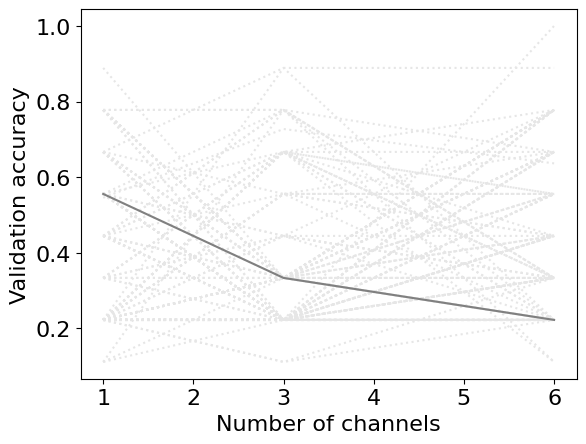

In [ ]:
for s in range(106):
  acc1 = Accuracy_progress['Accuracy 1'][s]
  acc2 = Accuracy_progress['Accuracy 2'][s]
  acc3 = Accuracy_progress['Accuracy 3'][s]
  plt.plot([1,3,6],[acc1,acc2,acc3],':',color='0.9')
meanacc = [acc1.mean(), acc2.mean(), acc3.mean()]
plt.plot([1,3,6], meanacc, color='0.5')
plt.xlabel('Number of channels', fontsize = 16)
plt.ylabel('Validation accuracy', fontsize = 16)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.savefig('valcurve1.png')

In [ ]:
Variance.sort_values('Variance', ascending=False).head(10).style.hide_index()

Subject,Variance,Std
96,0.206176,0.014771
34,0.206015,0.012616
7,0.205003,0.013311
48,0.204783,0.012917
42,0.201336,0.011511
35,0.199811,0.012319
27,0.199162,0.011779
44,0.198267,0.015123
29,0.198117,0.011567
54,0.197778,0.014159


In [ ]:
IdealVar.sort_values('Variance', ascending=False).head(10).style.hide_index()

<ipython-input-27-a34c07b94ab7>:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  IdealVar.sort_values('Variance', ascending=False).head(10).style.hide_index()


Subject,Variance,Std
21,0.959213,0.000000
46,0.938093,0.000000
30,0.930512,0.000000
61,0.920832,0.000000
18,0.919595,0.000000
104,0.918961,0.000000
50,0.911596,0.000000
1,0.910338,0.000000
45,0.908474,0.000000
35,0.907889,0.000000
